# Exploratory Analysis

### I-CARE: International Cardiac Arrest REsearch consortium Database

In [1]:
%reload_ext autoreload
%autoreload 2
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
sys.path.append("..")
sns.set_theme(style="whitegrid")
from util import compile_clinical_data

## Patient Metadata

In [3]:
root_path = Path("/media/hdd1/i-care/training/")

In [91]:
# Load and compile patient metadata
patient_df = compile_clinical_data(root_path)

In [ ]:
# Plot patient age distribution
plt.figure(figsize=(10, 6))
sns.histplot(patient_df["Age"], bins=15, kde=True)
plt.title("Patient Age Distribution")
plt.xlabel("Age")
plt.ylabel("Frequency")

In [ ]:
# Plot ROSC distribution
plt.figure(figsize=(10, 6))
sns.histplot(patient_df["ROSC"], bins=15, kde=True)
plt.title("Time to ROSC Distribution")
plt.xlabel("Time to ROSC (hr)")
plt.ylabel("Frequency")

Text(0.5, 0.98, 'Categorical Clinical Variable Count Summary')

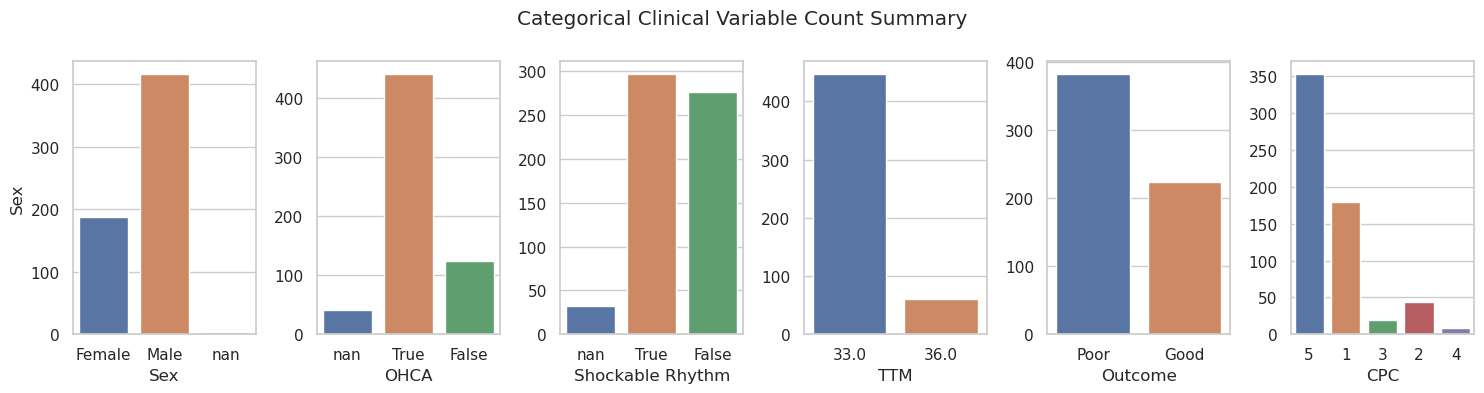

In [87]:
# Plot count plots for categorical columns
cat_columns = ["Sex", "OHCA", "Shockable Rhythm", "TTM", "Outcome", "CPC"]
plt.figure(figsize=(15, 4))
for i, col in enumerate(cat_columns):
    plt.subplot(1, len(cat_columns), i+1)
    sns.countplot(data=patient_df, x=col)
    if i == 0:
        plt.ylabel(col)
    else:
        plt.ylabel("")

plt.tight_layout()
plt.subplots_adjust(top=0.85)
plt.suptitle("Categorical Clinical Variable Count Summary")

## Signal Metadata

Add the following EEG signal metadata to patient dataframe:

* Sampling Frequency
* Average Recording Duration
* Max/Min Recording Duration
* Available Channels
* Utility Frequency
* Number of Hours with Recording

In [4]:
from util import compile_signal_metadata
metadata_df = compile_signal_metadata(root_path)

Text(0, 0.5, 'Count')

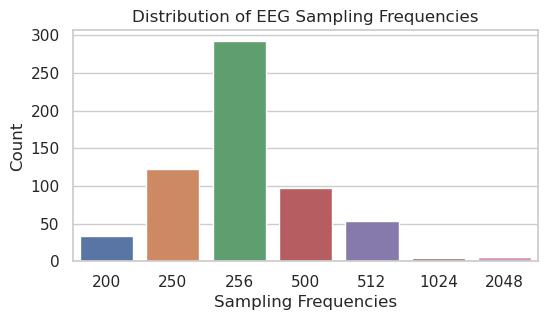

In [54]:
# What are the sampling frequencies for the signals?
plt.figure(figsize=(6, 3))
sns.countplot(data=metadata_df, x="Fs")
plt.title("Distribution of EEG Sampling Frequencies")
plt.xlabel("Sampling Frequencies")
plt.ylabel("Count")

Text(0.5, 1.0, 'Distribution of Hours Recorded')

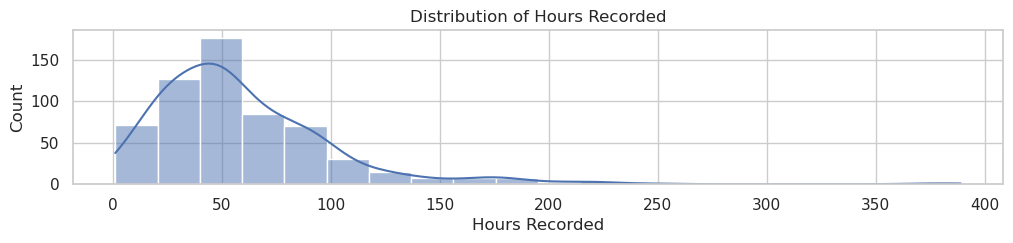

In [77]:
plt.figure(figsize=(12, 2))
sns.histplot(metadata_df["Hours Recorded"], bins=20, kde=True)
plt.title("Distribution of Hours Recorded")

## CPC Group Summary

In [157]:
# Merge the clinical and signal metadata dataframes.
df = pd.merge(patient_df, metadata_df, on="Patient")

In [174]:
# Create a pivot table by grouping CPC
pivot_df = df.pivot_table(index="CPC", aggfunc={
    "Patient": "count",
    "Age": "mean",
    "Sex": lambda x: (x=="Female").sum() / len(x) * 100,
    "ROSC": "mean",
    "OHCA": lambda x: (x=="True").sum() / len(x) * 100,
    "Shockable Rhythm": lambda x: (x=="True").sum() / len(x) * 100,
    "EEG Duration": "mean"
}).rename(columns={
    "Patient": "Number of Patients",
    "Age": "Average Age (years)",
    "Sex": "Female Sex (%)",
    "ROSC": "Return of Circulation (hr)",
    "OHCA": "Out of Hospital Arrest (%)",
    "Shockable Rhythm": "Shockable Rhythm (VFib/VT, %)",
    "EEG Duration": "EEG Duration (hr)"
}, index={
    "1": "CPC 1",
    "2": "CPC 2",
    "3": "CPC 3",
    "4": "CPC 4",
    "5": "CPC 5"
})

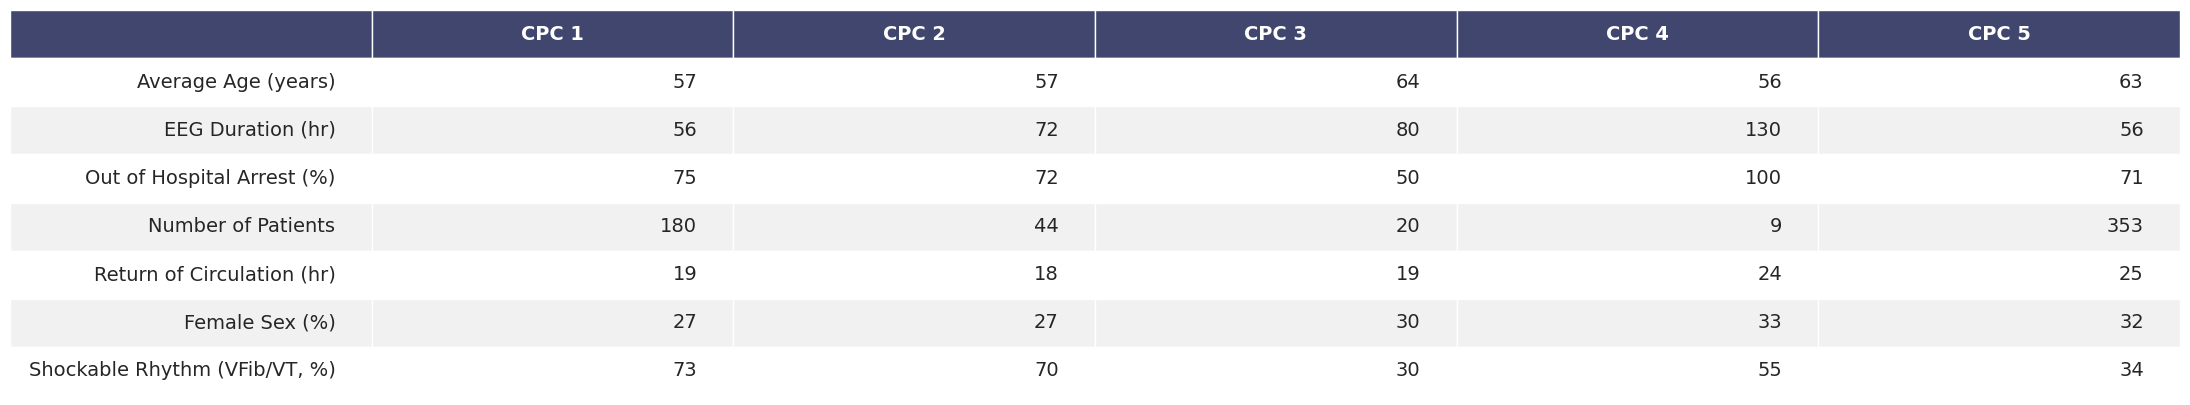

In [189]:
from util import render_mpl_table
fig, ax = render_mpl_table(pivot_df.T.astype(int), col_width=4.0)

## Find Channel Subset

The dataset has three different channel lengths {19, 20, 21}. We want to limit our analysis to 19 channels, a subset that all EEG records should include. Find what the 19 channels are, which channels are left out, and whether additional steps need to be taken to match channels between patients.

In [21]:
channel_df = metadata_df[["Patient", "Channels", "Channel Count"]]

In [138]:
channels = channel_df[channel_df["Channel Count"] == 20]["Channels"].tolist()

In [144]:
def are_lists_identical(list_of_lists):
    # sorted_lists = [sorted(inner_list) for inner_list in list_of_lists]
    sorted_lists = [inner_list for inner_list in list_of_lists]
    first_list = sorted_lists[0]

    mismatch = []
    match = []
    for sublist in sorted_lists[1:]:
        if sublist != first_list:
            mismatch.append(sublist)
        else:
            match.append(sublist)
    
    return mismatch, match

In [145]:
mismatch, match = are_lists_identical(channels)